In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the logistic regression dataset
df_log_reg = pd.read_csv("../../Data and data related codes/dataset_log_reg.csv")
df_log_reg['Date'] = pd.to_datetime(df_log_reg['Date'], errors='coerce')

# Filter for the last 2 months
end_date_log = df_log_reg['Date'].max()
start_date_log = end_date_log - pd.DateOffset(months=2)
df_last_2_months_log = df_log_reg[(df_log_reg['Date'] >= start_date_log) & (df_log_reg['Date'] <= end_date_log)]

# Prepare features (X) and target (y)
X_log = df_last_2_months_log.drop(columns=['Date', 'F_Close_pred_class'])  # Exclude Date and target
y_log = df_last_2_months_log['F_Close_pred_class']

# Step 1: Split data into training/validation and unseen test set
split_index_log = len(X_log) - 3
X_train_val_log, X_unseen_test_log = X_log.iloc[:split_index_log], X_log.iloc[split_index_log:]
y_train_val_log, y_unseen_test_log = y_log.iloc[:split_index_log], y_log.iloc[split_index_log:]

In [2]:
# Step 2: Standardize and remove skewness (fit only on training data)
scaler_log = StandardScaler()
X_train_scaled = scaler_log.fit_transform(X_train_val_log)
X_unseen_test_scaled = scaler_log.transform(X_unseen_test_log)

power_transformer_log = PowerTransformer()
X_train_transformed = power_transformer_log.fit_transform(X_train_scaled)
X_unseen_test_transformed = power_transformer_log.transform(X_unseen_test_scaled)

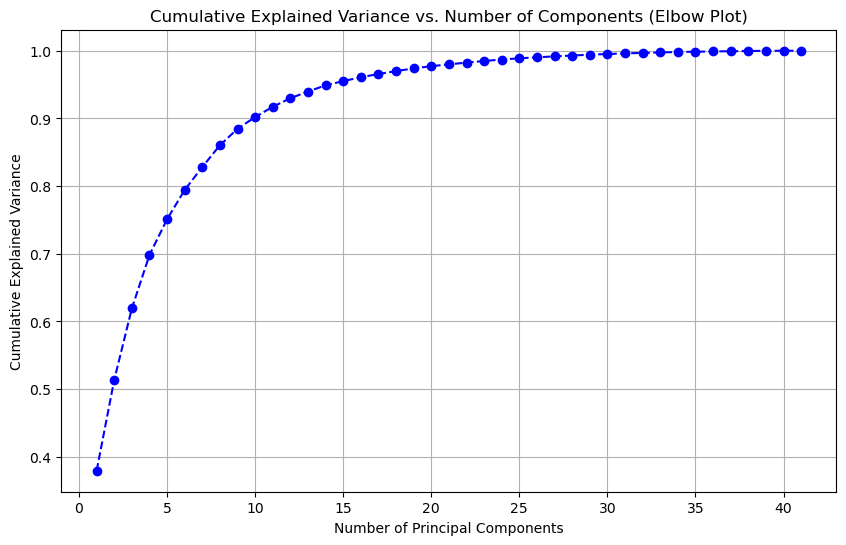

In [3]:
# Apply PCA

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA and determine the number of components
pca_log = PCA().fit(X_train_transformed)

# Scree plot for explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_log.explained_variance_ratio_) + 1), np.cumsum(pca_log.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components (Elbow Plot)')
plt.grid(True)
plt.show()

Grid Search Results with Accuracy for Logistic Regression:
                Model                                    Best Parameters  \
0  LogisticRegression  {'C': 0.1, 'penalty': 'l2', 'solver': 'libline...   

   Best Accuracy  
0            0.6  
Best model: LogisticRegression(C=0.1, solver='liblinear'), Accuracy: 0.6
Unseen Test Accuracy: 0.3333333333333333

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/envs/equity_vs_commodity/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

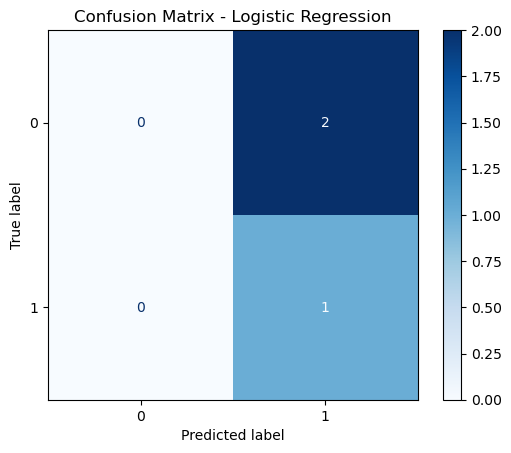

In [4]:
# Step 3: Apply PCA to training data and use the same PCA for test data
pca_log = PCA(n_components=11)  # Adjust based on explained variance plot
X_train_pca = pca_log.fit_transform(X_train_transformed)
X_unseen_test_pca = pca_log.transform(X_unseen_test_transformed)

# Step 4: Set up parameter grid for Logistic Regression with different regularizations
log_params = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type (L1 for Lasso, L2 for Ridge)
    'solver': ['liblinear']  # Required solver for 'l1' penalty
}

# Initialize Logistic Regression model
log_model = LogisticRegression()

# TimeSeriesSplit for cross-validation
tscv_log = TimeSeriesSplit(n_splits=5)

# GridSearchCV with TimeSeriesSplit for logistic regression
log_cv = GridSearchCV(log_model, log_params, scoring='accuracy', cv=tscv_log)

# Fit model on training and validation set
log_cv.fit(X_train_pca, y_train_val_log)

# Step 5: Collect accuracy and best parameters in a table
results_log = pd.DataFrame({
    'Model': ['LogisticRegression'],
    'Best Parameters': [log_cv.best_params_],
    'Best Accuracy': [log_cv.best_score_]
})

# Display the table
print("Grid Search Results with Accuracy for Logistic Regression:")
print(results_log)

# Choose the best model based on the highest accuracy
best_log_model = log_cv.best_estimator_
print(f"Best model: {best_log_model}, Accuracy: {log_cv.best_score_}")

# Step 6: Predict on the unseen test data
y_unseen_pred_log = best_log_model.predict(X_unseen_test_pca)
unseen_accuracy_log = accuracy_score(y_unseen_test_log, y_unseen_pred_log)
print(f"Unseen Test Accuracy: {unseen_accuracy_log}")

# Step 7: Optional - Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_unseen_test_log, y_unseen_pred_log))
ConfusionMatrixDisplay.from_estimator(best_log_model, X_unseen_test_pca, y_unseen_test_log, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

Unseen Test Accuracy (3 days): 0.3333333333333333


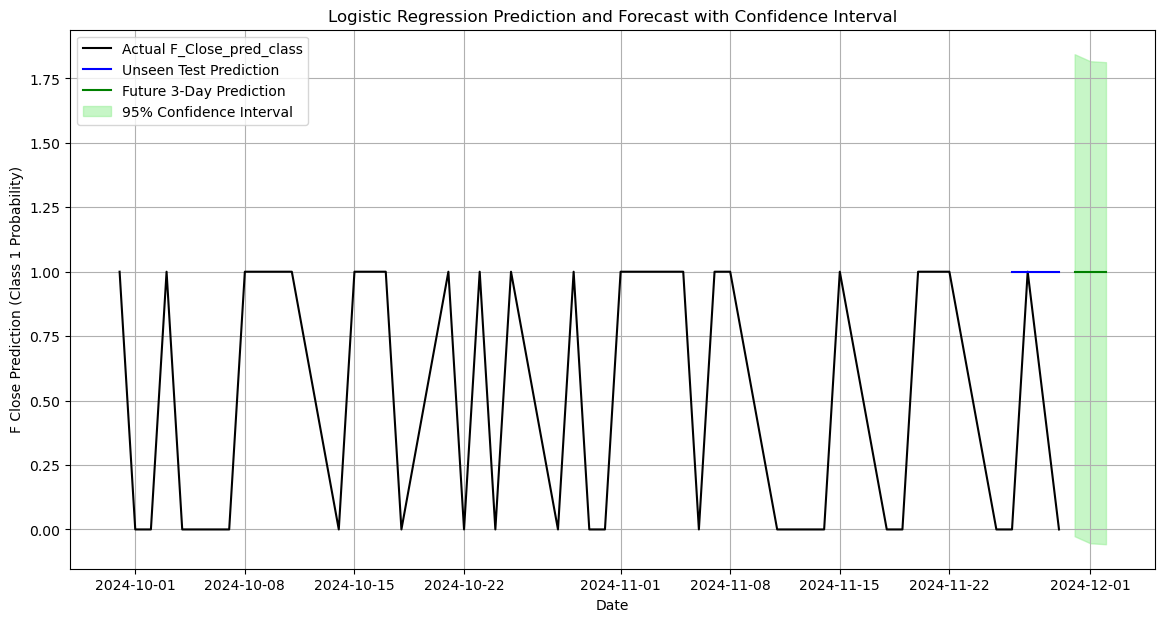

In [6]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 6: Predict on the last 3 days (unseen test data)
# Ensure consistent transformations
X_unseen_test_scaled = scaler_log.transform(X_unseen_test_log)
X_unseen_test_transformed = power_transformer_log.transform(X_unseen_test_scaled)
X_unseen_test_pca = pca_log.transform(X_unseen_test_transformed)

# Predict class labels for unseen test data
y_unseen_pred_log = best_log_model.predict(X_unseen_test_pca)

# Calculate accuracy for the unseen test data
unseen_test_accuracy = accuracy_score(y_unseen_test_log, y_unseen_pred_log)
print(f"Unseen Test Accuracy (3 days): {unseen_test_accuracy}")

# Step 7: Forecast the next 3 days using the best model
# Prepare future data
future_3_days_log = X_log.iloc[-3:]  # Original feature values for the last 3 days
future_scaled = scaler_log.transform(future_3_days_log)  # Apply scaling
future_transformed = power_transformer_log.transform(future_scaled)  # Apply power transformation
future_pca = pca_log.transform(future_transformed)  # Apply PCA

# Predict class labels for the future 3 days
future_predictions_log = best_log_model.predict(future_pca)

# Calculate confidence interval for predicted probabilities
y_unseen_pred_prob = best_log_model.predict_proba(X_unseen_test_pca)[:, 1]  # Probability of class 1
std_dev_log = np.std(y_unseen_pred_prob - y_unseen_test_log)

# Get the probability range for the forecasted data
future_pred_prob = best_log_model.predict_proba(future_pca)[:, 1]
upper_bound_log = future_pred_prob + (1.96 * std_dev_log)
lower_bound_log = future_pred_prob - (1.96 * std_dev_log)

# Plot the results for logistic regression prediction with confidence interval
plt.figure(figsize=(14, 7))

# Plot actual observed class labels for the last 2 months
plt.plot(df_last_2_months_log['Date'], y_log, label="Actual F_Close_pred_class", color='black')

# Plot predictions for the last 3 unseen days
plt.plot(df_last_2_months_log['Date'].iloc[-3:], y_unseen_pred_log, label="Unseen Test Prediction", color='blue')

# Future forecast for the next 3 days
future_dates_log = pd.date_range(df_last_2_months_log['Date'].iloc[-1] + pd.Timedelta(days=1), periods=3)
plt.plot(future_dates_log, future_predictions_log, label="Future 3-Day Prediction", color='green')

# Confidence interval for the forecast
plt.fill_between(future_dates_log, lower_bound_log, upper_bound_log, color='lightgreen', alpha=0.5, label="95% Confidence Interval")

# Labels and title
plt.xlabel("Date")
plt.ylabel("F Close Prediction (Class 1 Probability)")
plt.title("Logistic Regression Prediction and Forecast with Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Ensure the pipeline is applied consistently without leakage
# Transform unseen test data (if not already done correctly)
X_unseen_test_scaled = scaler_log.transform(X_unseen_test_log)
X_unseen_test_transformed = power_transformer_log.transform(X_unseen_test_scaled)
X_unseen_test_pca = pca_log.transform(X_unseen_test_transformed)

# Transform future data for forecasting
future_scaled = scaler_log.transform(future_3_days_log)  # Scale the future features
future_transformed = power_transformer_log.transform(future_scaled)  # Power transformation
future_pca = pca_log.transform(future_transformed)  # PCA transformation

# Predict for unseen test data and future data
y_unseen_pred_log = best_log_model.predict(X_unseen_test_pca)  # Unseen test predictions
future_predictions_log = best_log_model.predict(future_pca)  # Future forecast predictions

# Ensure actual values and predicted values align correctly
# Extract dates for the last 10 days
dates_last_ten_days = df_last_2_months_log['Date'].iloc[-10:]

# Extract actual values for the last 10 days
actual_values_last_ten_days = y_log.iloc[-10:]

# Initialize predicted values with NaN for the first 7 days of the 10-day window
predicted_values_last_ten_days = [np.nan] * 7 + list(y_unseen_pred_log)

# Create a DataFrame with actual and predicted values for the last 10 days
comparison_df = pd.DataFrame({
    'Date': dates_last_ten_days.values,
    'Actual F_Close_pred': actual_values_last_ten_days.values,
    'Predicted F_Close_pred': predicted_values_last_ten_days
})

# Generate future dates for the next 3 days
future_dates = pd.date_range(comparison_df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=3)

# Create a DataFrame for the forecasted 3 days
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Actual F_Close_pred': [np.nan] * 3,  # No actual values for future dates
    'Predicted F_Close_pred': future_predictions_log  # Forecasted predictions
})

# Append the forecasted data to the comparison DataFrame
comparison_df_with_forecast = pd.concat([comparison_df, forecast_df], ignore_index=True)

# Display the combined DataFrame
print(comparison_df_with_forecast)

         Date  Actual F_Close_pred  Predicted F_Close_pred
0  2024-11-15                  1.0                     NaN
1  2024-11-18                  0.0                     NaN
2  2024-11-19                  0.0                     NaN
3  2024-11-20                  1.0                     NaN
4  2024-11-21                  1.0                     NaN
5  2024-11-22                  1.0                     NaN
6  2024-11-25                  0.0                     NaN
7  2024-11-26                  0.0                     1.0
8  2024-11-27                  1.0                     1.0
9  2024-11-29                  0.0                     1.0
10 2024-11-30                  NaN                     1.0
11 2024-12-01                  NaN                     1.0
12 2024-12-02                  NaN                     1.0
